
<div class="markdown-google-sans">

# **Sarcasm Detection Notebook**
</div>

> This notebook demonstrates a sarcasm detection model using LSTM layers. It preprocesses data, visualizes word frequency, utilizes GloVe embeddings, builds an RNN model, and evaluates sarcasm detection with examples.

> The LSTM model is then integrated with streamlit and deployed as a web-app.


Outline:

I. [Exploratory Data Analysis](#eda)<br>
II. [Baseline Model : Naive Bayes](#naiveBayes)<br>
III. [Sarcasm Detection using LSTM](#lstm)<br>


<div class="markdown-google-sans">

# **Exploratory Data Analysis**
</div>
<a name="eda"></a>

## Importng necessary libraries

In [39]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import ModelCheckpoint

## Loading the dataset

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
data_1 = pd.read_json("/content/drive/MyDrive/data/sarcasm/Sarcasm_Headlines_Dataset.json", lines=True)
data_2 = pd.read_json("/content/drive/MyDrive/data/sarcasm/Sarcasm_Headlines_Dataset_v2.json", lines=True)
data =  pd.concat([data_1, data_2])
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


### DATA VISUALIZATION AND PREPROCESSING


In [4]:
def clean_text(text):
    text = text.lower()

    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    text = emoji.sub(r'', text)
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [5]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

def CleanTokenize(df):
    head_lines = list()
    lines = df["headline"].values.tolist()

    for line in lines:
        line = clean_text(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        head_lines.append(words)
    return head_lines

head_lines = CleanTokenize(data)
head_lines[0:10]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[['former',
  'versace',
  'store',
  'clerk',
  'sues',
  'secret',
  'black',
  'code',
  'minority',
  'shoppers'],
 ['roseanne',
  'revival',
  'catches',
  'thorny',
  'political',
  'mood',
  'better',
  'worse'],
 ['mom',
  'starting',
  'fear',
  'sons',
  'web',
  'series',
  'closest',
  'thing',
  'grandchild'],
 ['boehner',
  'wants',
  'wife',
  'listen',
  'come',
  'alternative',
  'debtreduction',
  'ideas'],
 ['jk', 'rowling', 'wishes', 'snape', 'happy', 'birthday', 'magical', 'way'],
 ['advancing', 'worlds', 'women'],
 ['fascinating', 'case', 'eating', 'labgrown', 'meat'],
 ['ceo', 'send', 'kids', 'school', 'work', 'company'],
 ['top', 'snake', 'handler', 'leaves', 'sinking', 'huckabee', 'campaign'],
 ['fridays', 'morning', 'email', 'inside', 'trumps', 'presser', 'ages']]

### Data Viz

(-0.5, 999.5, 499.5, -0.5)

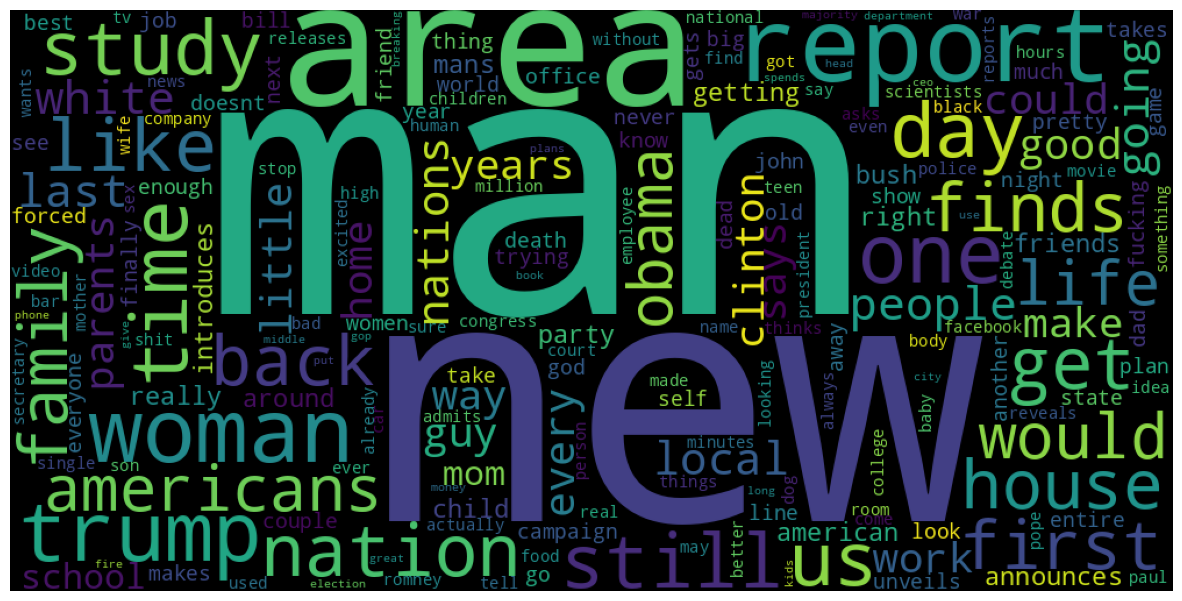

In [9]:
# Visualizing word cloud of most frequent words in sarcastic headlines
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator

pos_data = data.loc[data['is_sarcastic'] == 1]
pos_head_lines = CleanTokenize(pos_data)
pos_lines = [j for sub in pos_head_lines for j in sub]
word_could_dict=Counter(pos_lines)

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

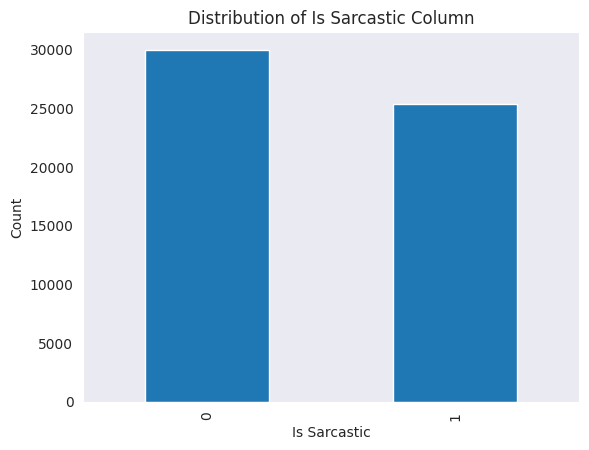

In [42]:
# prompt: check the distribution of then column is_sarcastic from data, bar plot to see how many instances of each class we have

data["is_sarcastic"].value_counts().plot(kind='bar')
plt.xlabel('Is Sarcastic')
plt.ylabel('Count')
plt.title('Distribution of Is Sarcastic Column')
plt.show()


### Average word length in a text


<ipython-input-46-afbf8d4c715c>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
<ipython-input-46-afbf8d4c715c>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')


Text(0.5, 0.98, 'Average word length in each text')

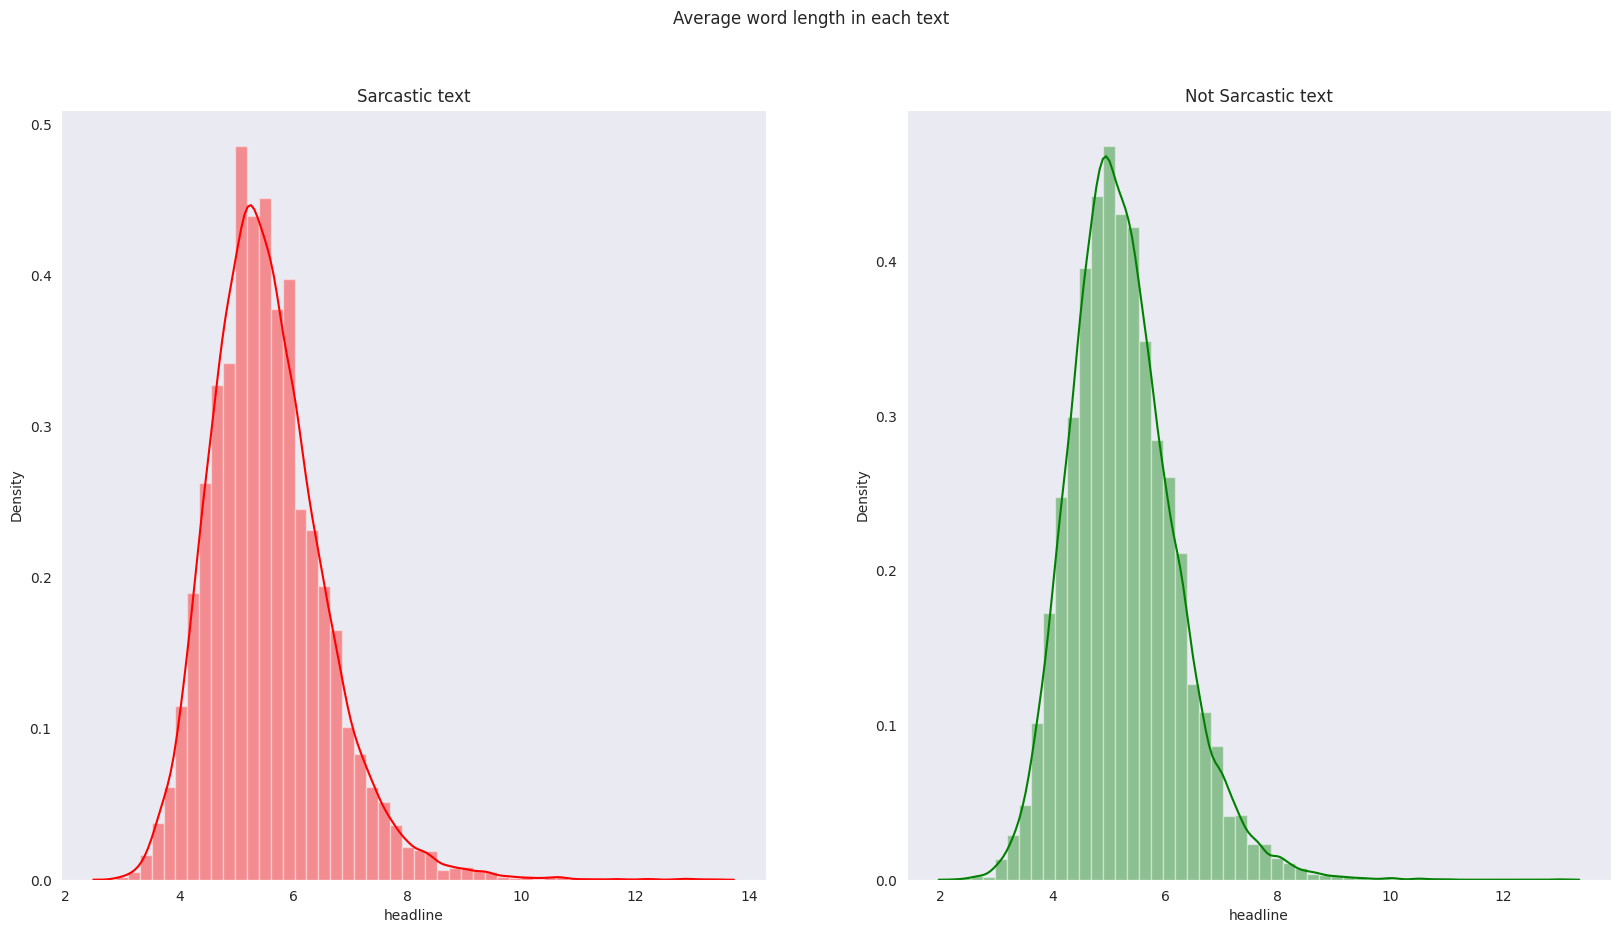

In [46]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=data[data['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Sarcastic text')
word=data[data['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Average word length in each text')



### Number of characters in texts


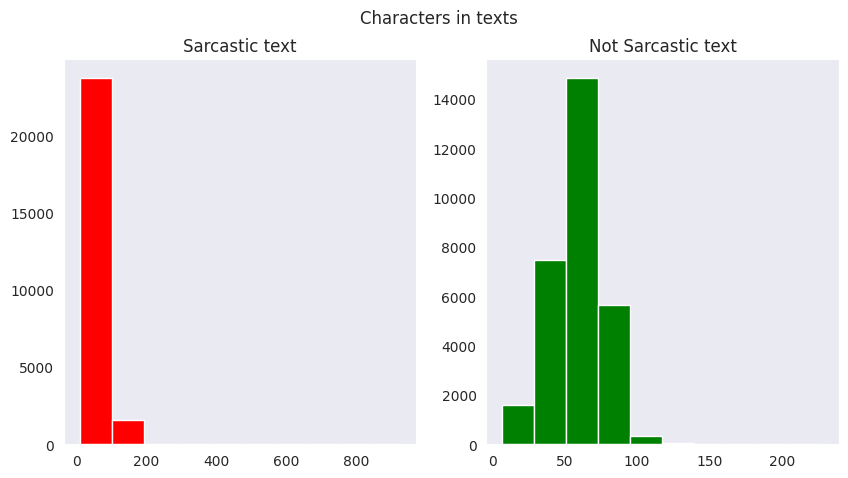

In [45]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=data[data['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=data[data['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Characters in texts')
plt.show()

### Train-test split

In [47]:
validation_split = 0.2
max_length = 25

# Tokenization and Sequencing
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(head_lines)
sequences = tokenizer_obj.texts_to_sequences(head_lines)

# Vocabulary and Padding
word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

# Padding Sequences to ensure uniform length for model input
lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['is_sarcastic'].values

# Shuffling and Splitting Data
indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

# Creating Training and Validation Sets
num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

unique tokens -  28657
vocab size - 28658


In [48]:
# prompt: save the tokenizer

import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer_obj, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [49]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (44263, 25)
Shape of y_train: (44263,)
Shape of X_test_pad: (11065, 25)
Shape of y_test: (11065,)


<div class="markdown-google-sans">

# **Baseline Model: Naive Bayes**
</div>
<a name="naiveBayes"></a>

In [36]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report


def clean_tokenize(row):
    line = row["headline"]
    line = clean_text(line)
    tokens = word_tokenize(line)
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    stop_words = set(stopwords.words("english"))
    words = [w for w in words if not w in stop_words]
    return ' '.join(words)

# Create a new DataFrame (data2) with cleaned and tokenized headlines
data2 = data.copy()  # Make a copy of the original data
data2["cleaned_headline"] = data.apply(clean_tokenize, axis=1)

# Split the data into training and testing sets
X_train_nc, X_test_nc, y_train_nc, y_test_nc = train_test_split(
    data2["cleaned_headline"], data2["is_sarcastic"], test_size=0.2, random_state=42
)

# Create a CountVectorizer to convert text data to a bag-of-words representation
vectorizer = CountVectorizer()
X_train_nc_vectorized = vectorizer.fit_transform(X_train_nc)
X_test_nc_vectorized = vectorizer.transform(X_test_nc)

# Initialize the Multinomial Naive Bayes classifier
naive_bayes_classifier = MultinomialNB()

# Train the classifier
naive_bayes_classifier.fit(X_train_nc_vectorized, y_train_nc)

# Make predictions on the test set
y_pred = naive_bayes_classifier.predict(X_test_nc_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test_nc, y_pred)
classification_report_result = classification_report(y_test_nc, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report_result)


Accuracy: 0.87

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.89      0.88      5878
           1       0.87      0.85      0.86      5188

    accuracy                           0.87     11066
   macro avg       0.87      0.87      0.87     11066
weighted avg       0.87      0.87      0.87     11066



<div class="markdown-google-sans">

# **Glove + LSTM Model**
</div>
<a name="lstm"></a>


## Load GloVe model

In [50]:
embeddings_index = {}
embedding_dim = 200
GLOVE_DIR = "/content/drive/MyDrive"
f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.200d.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


## Build the embedding layer

In [51]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
print(c)

24755


In [52]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

## Building the LSTM Model

In [53]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print('Summary of the built model...')
print(model.summary())

Summary of the built model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 200)           5731600   
                                                                 
 lstm (LSTM)                 (None, 64)                67840     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 5799505 (22.12 MB)
Trainable params: 67905 (265.25 KB)
Non-trainable params: 5731600 (21.86 MB)
_________________________________________________________________
None


### Training the model

In [54]:
history = model.fit(X_train_pad, y_train, batch_size=32, epochs=25, validation_data=(X_test_pad, y_test), verbose=2)

Epoch 1/25
1384/1384 - 69s - loss: 0.4824 - acc: 0.7689 - val_loss: 0.4037 - val_acc: 0.8157 - 69s/epoch - 50ms/step
Epoch 2/25
1384/1384 - 65s - loss: 0.3937 - acc: 0.8220 - val_loss: 0.3507 - val_acc: 0.8463 - 65s/epoch - 47ms/step
Epoch 3/25
1384/1384 - 64s - loss: 0.3414 - acc: 0.8479 - val_loss: 0.3297 - val_acc: 0.8587 - 64s/epoch - 46ms/step
Epoch 4/25
1384/1384 - 67s - loss: 0.3044 - acc: 0.8700 - val_loss: 0.2974 - val_acc: 0.8741 - 67s/epoch - 48ms/step
Epoch 5/25
1384/1384 - 64s - loss: 0.2718 - acc: 0.8843 - val_loss: 0.2817 - val_acc: 0.8844 - 64s/epoch - 46ms/step
Epoch 6/25
1384/1384 - 64s - loss: 0.2459 - acc: 0.8992 - val_loss: 0.2547 - val_acc: 0.8993 - 64s/epoch - 46ms/step
Epoch 7/25
1384/1384 - 64s - loss: 0.2246 - acc: 0.9073 - val_loss: 0.2465 - val_acc: 0.9062 - 64s/epoch - 46ms/step
Epoch 8/25
1384/1384 - 64s - loss: 0.2059 - acc: 0.9170 - val_loss: 0.2363 - val_acc: 0.9118 - 64s/epoch - 47ms/step
Epoch 9/25
1384/1384 - 66s - loss: 0.1888 - acc: 0.9245 - val_lo

### Visualize the learning plots

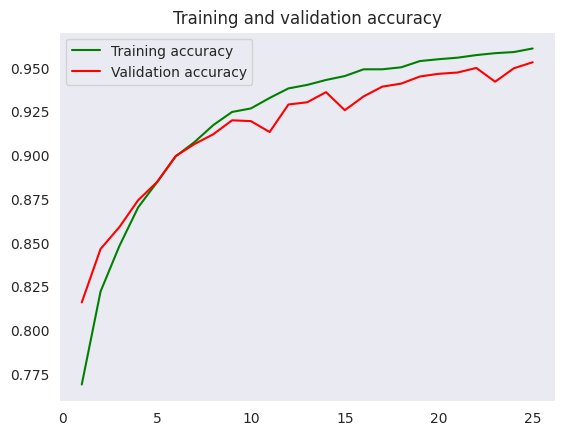

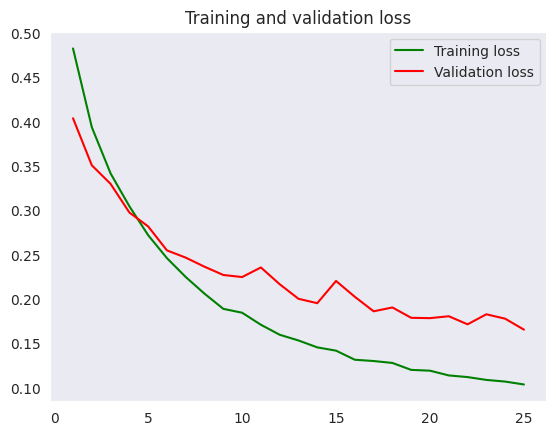

In [55]:
# Plot results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Testing with some sentences

In [56]:
def predict_sarcasm(s):
    x_final = pd.DataFrame({"headline":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model.predict(test_review_pad)
    pred*=100
    if pred[0][0]>=50: return "It's a sarcasm!"
    else: return "It's not a sarcasm."

In [57]:
predict_sarcasm("I was depressed. He asked me to be happy. I am not depressed anymore.")

1/1 [==============================] - 0s 430ms/step


"It's not a sarcasm."

In [ ]:
predict_sarcasm("You just broke my car window. Great job.")

1/1 [==============================] - 0s 39ms/step


"It's a sarcasm!"

In [ ]:
predict_sarcasm("You just saved my dog's life. Thanks a million.")

1/1 [==============================] - 0s 32ms/step


"It's not a sarcasm."

In [ ]:
predict_sarcasm("I want a million dollars!")

1/1 [==============================] - 0s 35ms/step


"It's not a sarcasm."

In [ ]:
predict_sarcasm("I just won a million dollars!")

1/1 [==============================] - 0s 34ms/step


"It's a sarcasm!"

### Model evaluation

In [60]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# Assuming you're doing binary classification, apply threshold to y_pred
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

print('Accuracy:', accuracy_score(y_test, y_pred_binary))
print('F1 score:', f1_score(y_test, y_pred_binary))
print('Recall:', recall_score(y_test, y_pred_binary))
print('Precision:', precision_score(y_test, y_pred_binary))


Accuracy: 0.9529145955716223
F1 score: 0.9487255191418167
Recall: 0.9452833888997842
Precision: 0.9521928091663374


### Saving the model

In [61]:
model.save('sarcasm_detector.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [62]:
# prompt: give me code to download the model using the Files of drive

from google.colab import files
files.download('sarcasm_detector.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>